In [1]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'  #Select GPU device
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #supress tensorflow info except error

import io
import argparse
import pathlib
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from model.utils import Param

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
def arg(args = ""):
    parser = argparse.ArgumentParser()
    parser.add_argument("cfg", help="config path", type=str)
    parser.add_argument("epoch", help="epoch", type=int)
    if args != "":
        return parser.parse_args(args)
    return parser.parse_args()

def parse_function(filename):
    image_string = tf.io.read_file(filename)
    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    image = image - 0.5
    image = image * 2.0
    image = tf.image.resize(image, (224, 224))
    return image

In [3]:
# model_dir = 'experiments/expt7_InceptionV3/'
# data_dir = '/home/ubuntu/dataset'
args = arg("./experiment/from_soft_to_tl_02/ 49".split())
config_path = args.cfg
params = Param(config_path)

## Export embeddings

In [4]:
baseModel = MobileNetV2(include_top=False,
                            weights=None,
                            input_shape=(224, 224, 3),
                            pooling="avg")

fc = tf.keras.layers.Dense(128)(baseModel.output)
l2 = tf.math.l2_normalize(fc)
model = Model(inputs=baseModel.input, outputs=l2)
model.summary()

model.load_weights(config_path+f"epoch-{args.epoch}")

empty_data = np.zeros((100, 19))
df = pd.DataFrame(data = empty_data, columns = [i for i in range(19)]).astype('object')
for label in tqdm(range(19)):
    ds_root = pathlib.Path(f"/home/ubuntu/dataset/test_100/Cow{label:02d}/")
    filenames = list(ds_root.glob('**/*'))
    filenames = [str(path) for path in filenames]
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(parse_function)
    dataset = dataset.batch(100)
    results = model.predict(dataset)
    for i, emb in enumerate(results):
        df.iloc[i, label] = emb

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

100%|██████████| 19/19 [00:12<00:00,  1.47it/s]


In [5]:
logdir = os.path.join(config_path, f"emb/{args.epoch}/")
if not os.path.exists(logdir):
    os.makedirs(logdir)
pkl_path = os.path.join(logdir, 'embeddings.pkl')
df.to_pickle(pkl_path)

## Compute distances between all embeddings

In [6]:
all_df = []
for ref_index in range(19):
    empty_data = np.zeros((99, 19)).astype(np.float32)
    df_length = pd.DataFrame(data = empty_data, columns = [i for i in range(19)])
    
    for label in tqdm(range(19)):
        for i in range(99):
            df_length.iloc[i, label] = np.linalg.norm(df.iloc[0, ref_index] - df.iloc[i+1, label])
    all_df.append(df_length)

100%|██████████| 19/19 [00:00<00:00, 38.15it/s]


## Plot figure

In [ ]:
plt.figure(figsize=(7,5))
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.grid(False)
sns.boxplot(data=all_df[18].loc[:,:17], ax=ax)

In [ ]:
# plt.figure(figsize=(1,5))
f, ax = plt.subplots(1, 1, figsize=(0.5, 5))
ax.yaxis.tick_right()
ax=ax
chart = sns.boxplot(data=all_df[18].loc[:,18], ax=ax, width=0.7)
# sns.boxplot(data=all_df[18].loc[:,18], width=0.2)

100%|██████████| 19/19 [00:06<00:00,  2.88it/s]


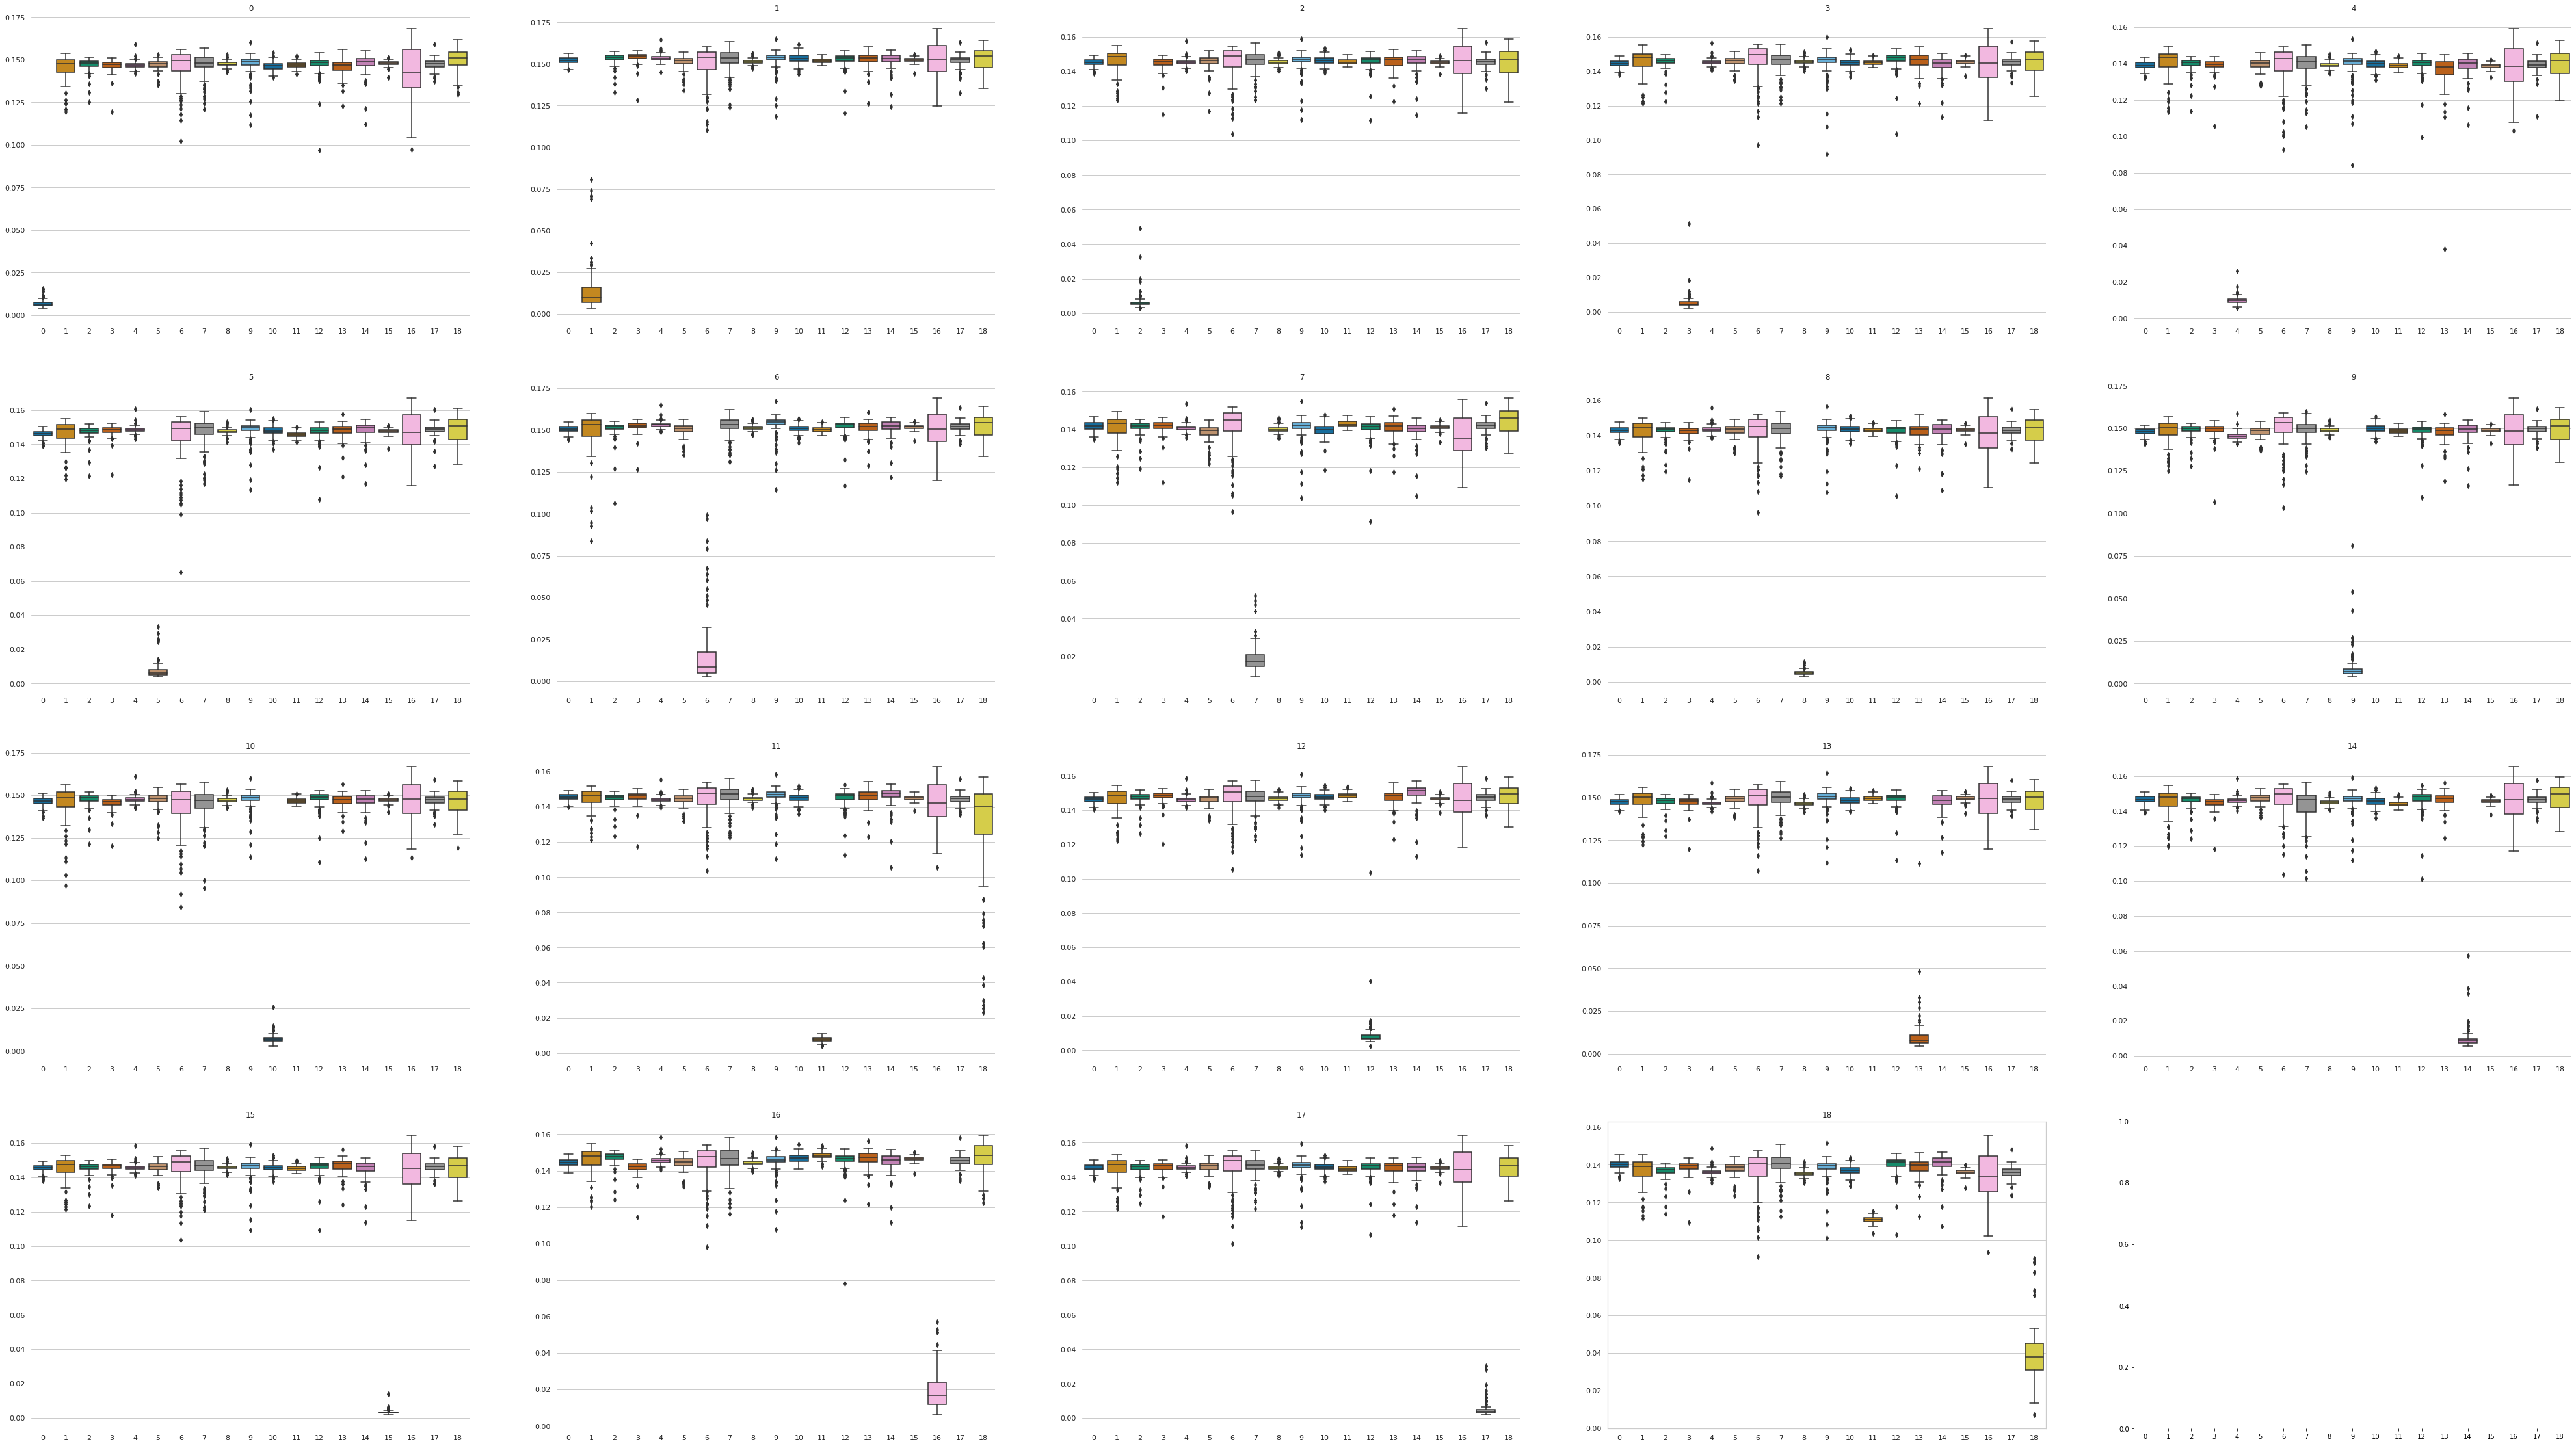

In [7]:
f, axes = plt.subplots(4, 5, figsize=(70, 40), sharex=True)
for i in tqdm(range(19)):   
    sns.set(style="whitegrid")
    chart = sns.boxplot(data=all_df[i], ax=axes[i//5, i%5])
    chart.axes.set_title(f'{i:2d}',fontsize=25)
    chart.set_xlabel('Cow id', fontsize=20)
    chart.set_ylabel('L2 distance', fontsize=20)

    sns.despine(left=True, bottom=True)
    
    plt.subplot(4, 5, i+1), sns.boxplot(data = all_df[i], palette="colorblind").set_title(f'{i:2d}')
img_path = os.path.join(logdir, 'distance_matrix_.jpg')
plt.savefig(img_path)

## Accuracy

In [8]:
database = []
for ref_index in range(19):
    database.append(df.iloc[0, ref_index])

In [9]:
for input_index in range(19):
    predicts = []
    for i in range(99):
        distances = []
        for x in range(19):
            distances.append(np.linalg.norm(df.iloc[i+1, input_index] - database[x]))
        predicts.append(np.argmin(distances))
    print(f'{input_index:2d} accuracy: {predicts.count(input_index)}%')

 0 accuracy: 99%
 1 accuracy: 99%
 2 accuracy: 99%
 3 accuracy: 99%
 4 accuracy: 99%
 5 accuracy: 99%
 6 accuracy: 97%
 7 accuracy: 99%
 8 accuracy: 99%
 9 accuracy: 99%
10 accuracy: 99%
11 accuracy: 99%
12 accuracy: 98%
13 accuracy: 98%
14 accuracy: 99%
15 accuracy: 99%
16 accuracy: 99%
17 accuracy: 99%
18 accuracy: 93%


##  Save embedding to pickle format
#### So next time don't need to compute all images again

In [ ]:
pkl_path = os.path.join(model_dir, 'embeddings.pkl')
df.to_pickle(pkl_path)

## Implement FaceNet Evaluation

In [10]:
import itertools

In [11]:
d = 0.75
TA = 0
Psame = 0
for i, j in tqdm(itertools.combinations([i for i in range(1900)],2)): # Create All pairs in testing dataset
    if i//100 == j//100: # if the pair is same label
        if np.linalg.norm(df.iloc[i%100, i//100] - df.iloc[j%100, j//100]) < d: # if L2 of this label < threshold
            TA += 1
        Psame += 1 # Count all pairs with same label

print(f"Accuracy:{TA/Psame:.5f}")

1804050it [00:04, 361382.81it/s]

Accuracy:1.00000


## Delete kernel

In [ ]:
%%javascript
Jupyter.notebook.session.delete()

<IPython.core.display.Javascript object>

In [4]:
logdir = os.path.join(config_path, f"emb/{args.epoch}/")
pkl_path = os.path.join(logdir, 'embeddings.pkl')
df = pd.read_pickle(pkl_path)

In [43]:
vecs = np.zeros((1900,128))
metas = np.zeros((1900))

In [44]:
for label in tqdm(range(19)):
    for i in range(100):
        vecs[label*100+i] = df[label][i]
        metas[label*100+i] = label

100%|██████████| 19/19 [00:00<00:00, 217.14it/s]


In [53]:
np.savetxt(config_path+f"{args.epoch:02d}vecs.tsv", vecs, fmt='%.10f', delimiter='\t')
np.savetxt(config_path+f"{args.epoch:02d}metas.tsv", metas, fmt='%i', delimiter='\t')